# Read QChem output file

In [129]:
import numpy as np
import re
# import for plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sgdml.utils import io
from sgdml.predict import GDMLPredict
from sgdml.utils import io, ui

## Functions

#### Read from QChem output file

In [145]:
def MDStep(file_name):
    # Some regex expressions
    num_str = re.compile('[+-]?\d+\.?\d*') # to find numbers
    time=re.compile(r'Time\s\(fs\)\s+(\d+\.\d+)')
    findforce=re.compile(r'Forces \(Hartrees\/Bohr\)')
    timestep = re.compile(r'TIME STEP #(\d+)\s\(t = (d\.\d+)\sa.u.\s=\s(d+\.\d+)')
    coord=re.compile(r'X=\s+([-]?\d\.\d+)D([+-]+\d+)\sY=\s+([-]?\d\.\d+)D([+-]+\d+)\sZ=\s+([-]?\d\.\d+)D([+-]+\d+)')
    endcoord=re.compile(r'MW cartesian velocity\:')
    #######
    temp = []
    time = []
    energy = []
    crd = [] # store coordinates in 2D array
    atoms = []
    grad = []
    s = 1.0
    step = 0
    startdyn = 0
    with open(file_name, 'r') as Qfile:
        data=Qfile.readlines()
    for i in range(len(data)):
        # TIME STEP #1 (t = 0.000 a.u. = 0.00000 fs)
        if i==8:
             print(i,data[i])
        if re.search(r'TIME STEP #',data[i]):
            fsec = float(re.findall(r'=\s(\d+\.\d+)\sfs',data[i])[0])
            time.append(fsec)
            startdyn = 1
            # Instantaneous Temperature = 291.9 K
        if re.search(r'Instantaneous Temperature =',data[i]):
            temperature = float(re.findall(r'=\s(\d+\.\d+)\sK',data[i])[0])
            temp.append(temperature)
            i+=1 # Move forward to coordinates
            #    1      O       1.3875858765     0.0114645102     0.1090411228
            #    2      H       1.7395762231     0.7248323964    -0.4529874171
            #    3      H       1.7383622270    -0.7920238234    -0.2840530212
            cols = []
            a = []
            i+=4 # skip forward to geometry
            while re.search(r'----',data[i]) is None: 
                atom = re.findall(r'\s([A-Z])\s',data[i])
                a.append(atom)
                sx=re.findall(r'([-]?\d\.\d+)\s+',data[i])
                cols.append(list(s*(1.0) for s in list(map(float, sx[0:3]))))                
                i+=1
            crd.append(cols)
            natom = len(a)
            atoms.append(a)
        
        ## Find energy
        if startdyn and re.search(r'Total energy in the final basis set = ',data[i]):
            total_energy = float(re.findall(r'=\s+([-]?\d+\.\d+)',data[i])[0])
            energy.append(total_energy)
        if startdyn and re.search(r'Gradient of SCF Energy',data[i]):
            cols=[]
            i+=2
            # print("Found gradient...", data[i])
            # Gradient of SCF Energy
            # 1           2           3           4           5
            # 1  -0.0238419   0.1260465  -0.0760941  -0.0128590  -0.0132516
            # 2   0.0486590  -0.0115856  -0.0462774   0.0210580  -0.0118539
            #  3  -0.0000008  -0.0000069  -0.0000101   0.0000170   0.0000008
            # Max gradient component =       1.260E-01
            # print('Number of atoms: ',natom)
            while re.search(r'Max gradient component',data[i]) is None: 
                sx=re.findall(r'([-]?\d\.\d+)\s+',data[i])
                cols.append(list(s*(1.0) for s in list(map(float, sx[0:natom]))))                
                i+=1
            gradcomp = []
            # print(cols)
            for i in np.arange(natom):
                gradcomp.append([cols[0][i],cols[1][i],cols[2][i]])
            # print(gradcomp) # Checks out, correct atoms and x, y, z components
            grad.append(gradcomp)
    print("Completed read of file\n Coordinates, time(fsec), temperature(K), energy(Hartree) returned...")
    
    sR = np.array(crd)
    energy = energy[:]
    time = time[1:]
    temp = temp[1:]
    sR = sR[1:]
    atoms=[x for l in atoms[0] for x in l]
    gradarr = np.array(grad)
    gradx = gradarr[:,0,0]
    print("gradarr shape: ", np.shape(gradarr))
    print(" Number of atoms: ",natom)
    gradsq = np.square(gradarr)
    print("gradsq: ",gradsq[0])
    gradmag = []
    for i in np.arange(np.shape(gradarr)[0]):
        gradmag.append(np.sum(np.sqrt(gradsq[i])))
    print('gradmag: ',gradmag[0])
    print("Gradarr: ",gradarr[0,:,:])
    
    #for an in np.arange(1,natom):
    #    gradmag = np.append(gradmag, np.sqrt(gradarr[:,i,0]**2+gradarr[:,i,1]**2+gradarr[:,i,2]**2))
    print("gradmag shape: ", np.shape(gradmag))
    print(np.asarray(time).shape, np.asarray(energy).shape)
    print(np.asarray(grad).shape, np.asarray(gradx).shape)
    ## Plot energy ##
    zero_energy = np.array(energy) - min(np.array(energy))
    plt.scatter(time,zero_energy)
    plt.tight_layout()
    plt.xlabel("time [fsec]")
    plt.ylabel("energy [Hartree]")
    plt.title(file_name+"(QChem)")
    plt.savefig(file_name+".png",dpi=300, bbox_inches = "tight")
    plt.show()
    ## Plot gradient ##
    plt.scatter(time,gradx)
    plt.tight_layout()
    plt.xlabel("time [fsec]")
    plt.ylabel("x gradient [Hartree]/Bohr")
    plt.title(file_name+" Gradient (QChem)")
    plt.savefig(file_name+"_gradient.png",dpi=300, bbox_inches = "tight")
    plt.show()
    ## Plot gradient magnitude ##
    plt.scatter(time,gradmag)
    plt.tight_layout()
    plt.xlabel("time [fsec]")
    plt.ylabel("gradient magnitude [Hartree]/Bohr")
    plt.title(file_name+" Gradient (QChem)")
    plt.savefig(file_name+"_gradient_mag.png",dpi=300, bbox_inches = "tight")
    plt.show()
    ## Plot gradient magnitude overlay energy ##
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
    fig, ax1 = plt.subplots(figsize=(16,9)) 
    color = 'tab:red'
    ax1.grid(color = 'red', linestyle = '--', linewidth = 0.5)
    ax1.set_xlabel("time [fsec]") 
    ax1.set_ylabel("gradient magnitude [Hartree/Bohr]", color = color) 
    ax1.scatter(time,gradmag,   color = color, label ='rms gradient')
    ax1.tick_params(axis ='y', labelcolor = color)
    ax1.set_ylim(0,np.max(gradmag)*1.2)
    ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax1.yaxis.set_major_locator(plt.MaxNLocator(10))
    #ax1.xaxis.set_major_locator(MultipleLocator(30))
    ax1.xaxis.set_major_formatter('{x:.0f}')
# For the minor ticks, use no labels; default NullFormatter.
    ax1.xaxis.set_minor_locator(MultipleLocator(40))
    ax1.tick_params(which='both', width=2)
    ax1.tick_params(which='major', length=7)
    ax1.tick_params(which='minor', length=4, color='r')
    ## 2nd axis energy
    ax2 = ax1.twinx() 
    color = 'tab:green'
    ax2.grid(color = color, linestyle = '-.', linewidth = 0.5)
    ax2.set_ylabel('energy[Hartree]', color = color) 
    ax2.scatter(time, zero_energy, color = color,label ='energy') 
    ax2.tick_params(axis ='y', labelcolor = color)

    ax2.set_ylim(0, np.max(zero_energy)*1.2)
    
    ax2.tick_params(which='both', width=2)
    ax2.tick_params(which='major', length=7)
    ax2.tick_params(which='minor', length=4, color='r')
    ax2.yaxis.set_major_locator(plt.MaxNLocator(10))
    ax2.yaxis.set_minor_locator(plt.MaxNLocator(40))
    fig.tight_layout()
    
    plt.title(file_name+" Gradient (QChem)")
    plt.legend()
    plt.savefig(file_name+"_gradient_mag_energy.png",dpi=300, bbox_inches = "tight")
    plt.show()
    ## return ##
    
    return sR,time,temp,energy, gradarr, atoms

### extended xyz format write 
File to be used for training of sGDML 
<div class="alert alert-block alert-info"> Below is an example of an extended xyz file:
</div>
<code>
9
-97088.53328354699
C	-0.019177078255	0.565281506616	-0.017707166769	0.00  0.00 0.00
C	-1.322541010044	-0.257863017132	0.021104784603	0.00  0.00 0.00
O	1.20740778407	-0.240470008061	0.052343885974	0.00  0.00 0.00
H	0.112915342493	1.272309700543	-0.830045235762	0.00  0.00 0.00
H	0.158814392784	1.116626422051	0.869682199341	0.00  0.00 0.00
H	-1.087634829566	-1.149513478699	0.663030580516	0.00  0.00 0.00
H	-2.2950373724	0.282895316258	0.198602896473	0.00  0.00 0.00
H	-1.305725447355	-0.565837176562	-1.040260047316	0.00  0.00 0.00
H	1.229837602444	-0.800426536788	-0.732200699668	0.00  0.00 0.00
</code>


In [131]:
def write_exyz(atoms,energy,coord,filename):
    numatoms = np.shape(atoms)[1]
    numsteps = np.shape(atoms)[0]
    f  = open(filename,'w')
    for i in np.arange(numsteps):
        f.write(str(numatoms)+"\n")
        f.write(str(energy[i])+"\n")
        for j in np.arange(numatoms):
            geom = '{0:9.6f} {1:9.6f} {2:9.6f} '.format(coord[i][j][0],coord[i][j][1],coord[i][j][2])
            geom_line = atoms[i][j][0]+"  "+geom+" 0.0000 0.0000 0.0000\n"
            f.write(geom_line)
    return   

### Prepare sGDML arrays

In [132]:
def prep_sgdml(R,atoms,E,F):    
    z = io.z_str_to_z(atoms)
    n_atoms = len(z)
    #F = np.hstack(F)
    fshape = np.shape(F)
    ts = int(fshape[0]/(n_atoms*3))
    print(fshape)
    factor = 627.5/0.529177 # (kcal/mol)/Angstrom 
    print("Factor: ",factor)
    print("F shape: ",np.shape(F))
    #F = F.reshape(-1, n_atoms, 3) #* factor #1185.8*2 #43.59 #0.529 #627.5/0.529 #1185.8 # 23.062063375661/0.529 = 43.59 Remove negative sign to shift between gradient and force
    F = -F*factor
    print("F shape after: ",np.shape(F))
    #R = np.hstack(R)
    R = R[:fshape[0]] # Limit size of carts to that of forces
    print("R shape: ",np.shape(R))
    #R = R.reshape(-1,n_atoms, 3)
    print("R shape after: ",np.shape(R))
    # E = np.array(E[:ts])*627.51 # Limit size of carts to that of forces
    E = np.array(E) *627.51 # Limit size of carts to that of forces
    print("Emax: %6.2f Emin: %6.2f" %(np.max(E),np.min(E)))
    Enorm = (E -np.min(E))
    plt.hist(Enorm)
    plt.title("Energy distribution")
    plt.savefig('EDist_h2o_read.png')
    z = np.array(z)
    print("Found", n_atoms," atoms and ",ts," time steps.")
    return R, z, E, F

## Data Analysis

#### Read QChem output file

#### AIMD step #1
#### Gradient of SCF Energy
            1           2           3           4           5
    1   0.0299728  -0.0521461   0.0265894  -0.0021809  -0.0022352
    2   0.0185103  -0.0177727   0.0110087  -0.0071762  -0.0045701
    3   0.0696883  -0.0591242   0.0376955  -0.0238841  -0.0243756
 Max gradient component =       6.969E-02
 RMS gradient           =       3.279E-02

### extended xyz file with gradient x, y,z components at end
9 <br>
-97089.07088252231<br>
3 C	0.005520567875	0.591490055517	-0.000813817516	-10.203010550722	33.656348909911	-1.91316346513<br>

if line_i >= 2:
            R.append(list(map(float, cols[1:4])))
            if file_i == 0:  # first molecule
                z.append(io._z_str_to_z_dict[cols[0]])
            F.append(list(map(float, cols[4:7])))
            

In [133]:
np.square(np.array([ 0.0299728,  0.0185103,  0.0696883]))
np.sqrt(np.sum(np.array([[8.98368740e-04, 3.42631206e-04, 4.85645916e-03],
 [2.71921575e-03, 3.15868865e-04, 3.49567103e-03],
 [7.06996192e-04, 1.21191476e-04, 1.42095072e-03],
 [4.75632481e-06, 5.14978464e-05, 5.70450233e-04],
 [4.99611904e-06, 2.08858140e-05, 5.94169875e-04]])))

0.1269807440175478

## Now read QChem file using function 

8 output file: 

Completed read of file
 Coordinates, time(fsec), temperature(K), energy(Hartree) returned...
gradarr shape:  (2218, 5, 3)
 Number of atoms:  5
gradsq:  [[8.98368740e-04 3.42631206e-04 4.85645916e-03]
 [2.71921575e-03 3.15868865e-04 3.49567103e-03]
 [7.06996192e-04 1.21191476e-04 1.42095072e-03]
 [4.75632481e-06 5.14978464e-05 5.70450233e-04]
 [4.99611904e-06 2.08858140e-05 5.94169875e-04]]
gradmag:  0.38693010000000005
Gradarr:  [[ 0.0299728  0.0185103  0.0696883]
 [-0.0521461 -0.0177727 -0.0591242]
 [ 0.0265894  0.0110087  0.0376955]
 [-0.0021809 -0.0071762 -0.0238841]
 [-0.0022352 -0.0045701 -0.0243756]]
gradmag shape:  (2218,)
(2218,) (2218,)
(2218, 5, 3) (2218,)


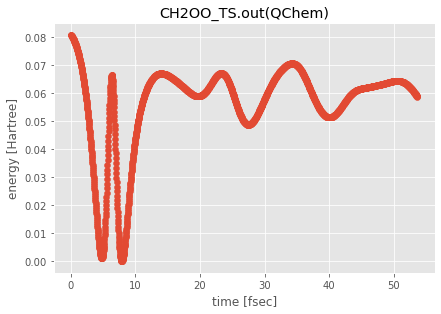

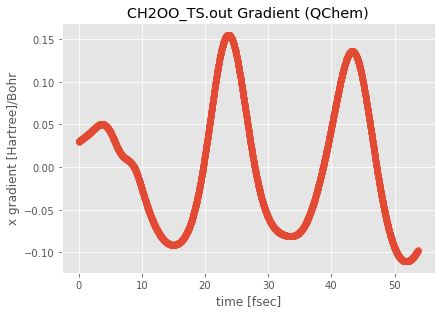

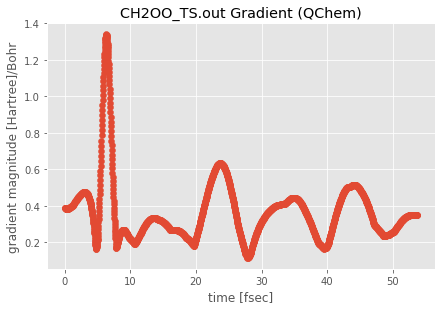

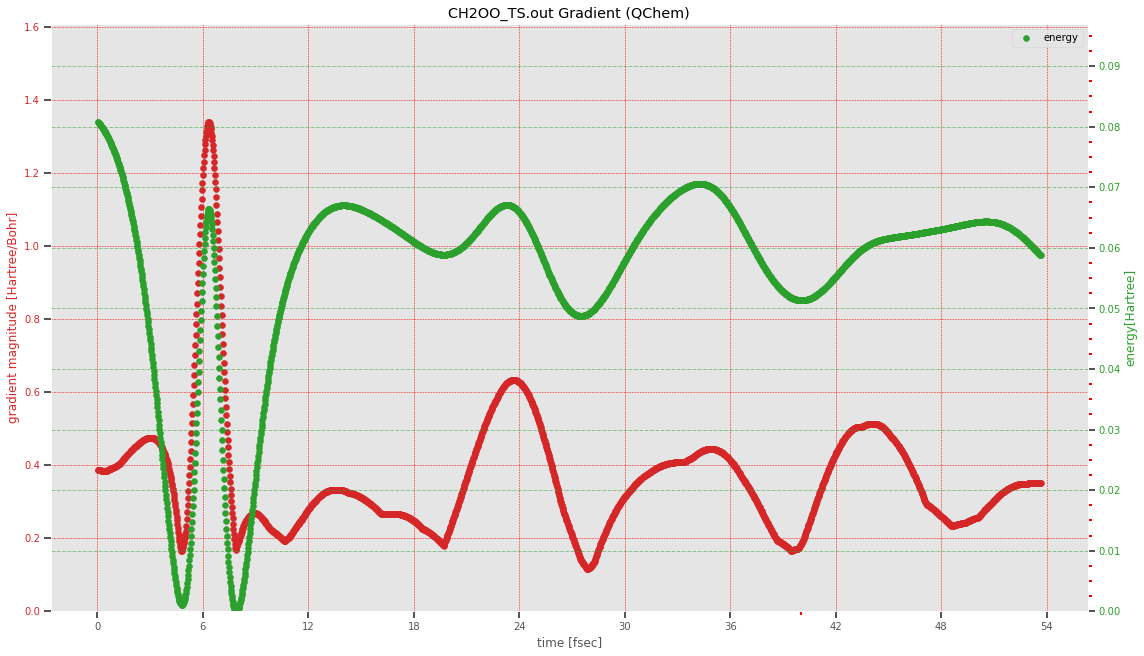

['C', 'O', 'H', 'H', 'H']
(2218, 5, 3)


In [146]:
filename='CH2OO_TS.out'
coord,time,temp,energy,grad, atoms = MDStep(filename)
print(atoms)
print(np.shape(grad))

In [135]:
coord[0]

array([[-3.38597528,  0.55317658,  0.09241982],
       [-2.25276317,  0.45651693, -0.6119664 ],
       [-1.14570973,  0.77862674,  0.39251022],
       [-4.02941758,  1.34990838, -0.33610792],
       [-3.91158367, -0.42313617,  0.09778202]])

            Standard Nuclear Orientation (Angstroms)
    I     Atom           X                Y                Z
 ----------------------------------------------------------------
    1      C      -3.3859914784     0.5532529142     0.0924577027
    2      O      -2.2527570066     0.4564474549    -0.6120753369
    3      H      -1.1453161338     0.7791117560     0.3932167368
    4      H      -4.0294627528     1.3499269579    -0.3355720495
    5      H      -3.9118370090    -0.4234459930     0.0978174490
 ----------------------------------------------------------------

## Now prepare sDGML arrays

(2218, 5, 3)
Factor:  1185.8036158034079
F shape:  (2218, 5, 3)
F shape after:  (2218, 5, 3)
R shape:  (2218, 5, 3)
R shape after:  (2218, 5, 3)
Emax: -72116.81 Emin: -72167.51
Found 5  atoms and  147  time steps.


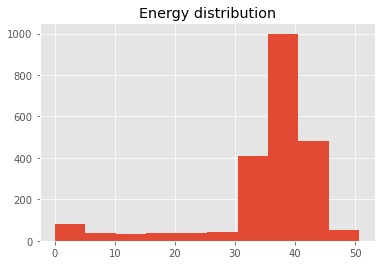

In [136]:
R, z, E, F = prep_sgdml(coord, atoms,energy,grad) 

In [137]:
R[0]

array([[-3.38597528,  0.55317658,  0.09241982],
       [-2.25276317,  0.45651693, -0.6119664 ],
       [-1.14570973,  0.77862674,  0.39251022],
       [-4.02941758,  1.34990838, -0.33610792],
       [-3.91158367, -0.42313617,  0.09778202]])

## Store data in sGDML .npz file
- Write out .npz file for processing with command line sGDML utility

In [138]:
name = 'CH2OO'
filename = name+"_AIMD"
# Base variables contained in every model file.


base_vars = {
    'type': 'd',
    'code_version': 'QChem 6.1',
    'name': name,
    'theory': 'QChem',
    'R': R,
    'z': z,
    'F': F,
}
base_vars['r_unit'] = 'Ang'
base_vars['e_unit'] = 'kcal/mol'
base_vars['F_min'], base_vars['F_max'] = np.min(F.ravel()), np.max(F.ravel())
base_vars['F_mean'], base_vars['F_var'] = np.mean(F.ravel()), np.var(F.ravel())

print('Please provide a description of the length unit used in your input file, e.g. \'Ang\' or \'au\': ')
print('Note: This string will be stored in the dataset file and passed on to models files for later reference.')
base_vars['r_unit'] = 'Ang'

print('Please provide a description of the energy unit used in your input file, e.g. \'kcal/mol\' or \'eV\': ')
print('Note: This string will be stored in the dataset file and passed on to models files for later reference.')
base_vars['e_unit'] = 'kcal/mol'

if E is not None:
    base_vars['E'] = E
    base_vars['E_min'], base_vars['E_max'] = np.min(E), np.max(E)
    base_vars['E_mean'], base_vars['E_var'] = np.mean(E), np.var(E)
else:
    print(ui.color_str('[INFO]', bold=True) + ' No energy labels found in dataset.')
keys = ['z', 'R', 'E', 'F']
for k in keys:
    d = base_vars[k]
    print(np.shape(d))
    if type(d) is np.ndarray:
            print(k)
            d = d.ravel()
            print(np.shape(d))
dataset_file_name = filename + '.npz'
base_vars['md5'] = io.dataset_md5(base_vars)
np.savez_compressed(dataset_file_name, **base_vars)
print(ui.color_str('[DONE]', fore_color=ui.GREEN, bold=True))

Please provide a description of the length unit used in your input file, e.g. 'Ang' or 'au': 
Note: This string will be stored in the dataset file and passed on to models files for later reference.
Please provide a description of the energy unit used in your input file, e.g. 'kcal/mol' or 'eV': 
Note: This string will be stored in the dataset file and passed on to models files for later reference.
(5,)
z
(5,)
(2218, 5, 3)
R
(33270,)
(2218,)
E
(2218,)
(2218, 5, 3)
F
(33270,)
[DONE]


In [139]:
np.shape(R)

(2218, 5, 3)

In [140]:
len(energy), len(time)

(2218, 2218)

In [147]:
np.shape(temp)

(2218,)

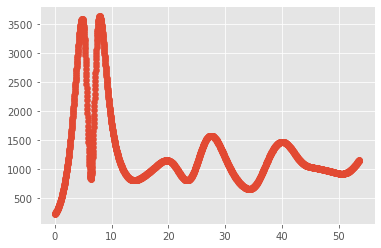

In [148]:
plt.scatter(time,temp)

In [133]:
filename='QChem_waterdimer_output192201.txt'
coord,time,temp,energy,grad, atoms = MDStep(filename)

8  Q-Chem 6.0, Q-Chem, Inc., Pleasanton, CA (2022)

Completed read of file
 Coordinates, time(fsec), temperature(K), energy(Hartree) returned...


In [134]:
np.shape(energy)

(1000,)

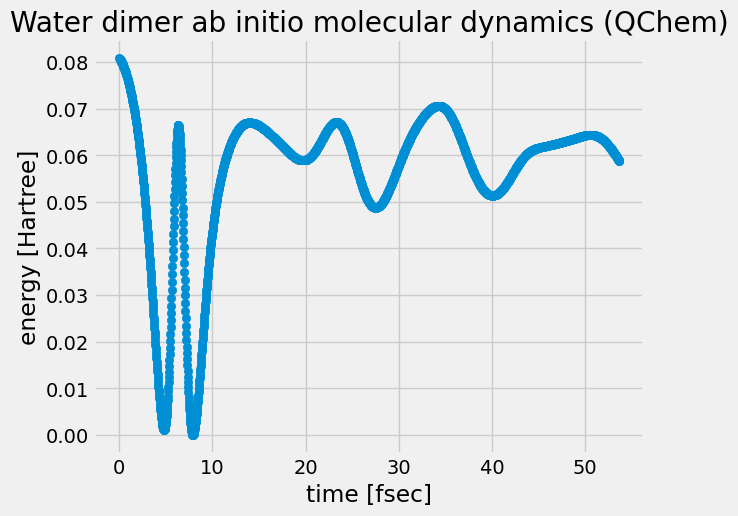

In [57]:
zero_energy = np.array(energy) - min(np.array(energy))
plt.scatter(time,zero_energy)
plt.tight_layout()
plt.xlabel("time [fsec]")
plt.ylabel("energy [Hartree]")
plt.title("Water dimer ab initio molecular dynamics (QChem)")
plt.savefig("energy_water_dimer.png",dpi=300, bbox_inches = "tight")

In [48]:
filename='output192979.txt'
coord,time,temp,energy,atoms = MDStep(filename)

8  Q-Chem 6.0, Q-Chem, Inc., Pleasanton, CA (2022)

Completed read of file
 Coordinates, time(fsec), temperature(K), energy(Hartree) returned...


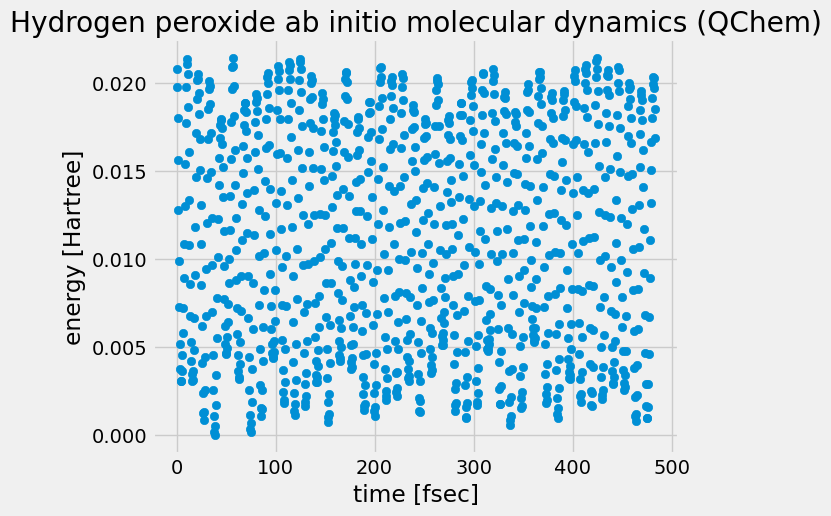

In [49]:
zero_energy = np.array(energy) - min(np.array(energy))
plt.scatter(time,zero_energy)
plt.tight_layout()
plt.xlabel("time [fsec]")
plt.ylabel("energy [Hartree]")
plt.title("Hydrogen peroxide ab initio molecular dynamics (QChem)")
plt.savefig("energy_peroxide.png",dpi=300, bbox_inches = "tight")

In [63]:
filename = "syn-MVK-oxide-aims.txt"
coord,time,temp,energy,atoms = MDStep(filename)

8  Q-Chem 6.0, Q-Chem, Inc., Pleasanton, CA (2022)

Completed read of file
 Coordinates, time(fsec), temperature(K), energy(Hartree) returned...


In [1]:
write_exyz(atoms,energy,coord,"syn-MVK-oxo.xyz")

NameError: name 'write_exyz' is not defined

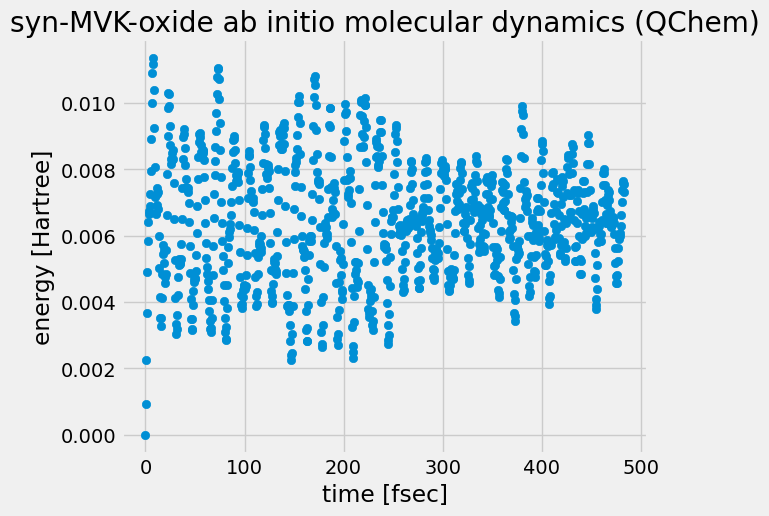

In [16]:
zero_energy = np.array(energy) - min(np.array(energy))
plt.scatter(time,zero_energy)
plt.tight_layout()
plt.xlabel("time [fsec]")
plt.ylabel("energy [Hartree]")
plt.title("syn-MVK-oxide ab initio molecular dynamics (QChem)")
plt.savefig("syn-MVK-oxide.png",dpi=300, bbox_inches = "tight")

### syn-MVK-oxide 1500K


In [5]:
filename = "syn-MVK-oxide-1500K.txt"
coord,time,temp,energy,atoms = MDStep(filename)

8  Q-Chem 6.0, Q-Chem, Inc., Pleasanton, CA (2022)

Completed read of file
 Coordinates, time(fsec), temperature(K), energy(Hartree) returned...


In [8]:
write_exyz(atoms,energy,coord,"syn-MVK-oxo-1500K.xyz")

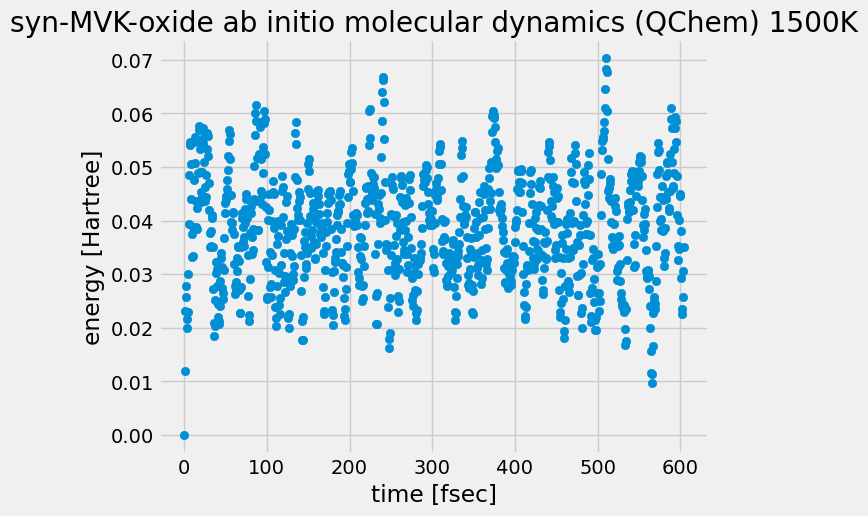

In [7]:
zero_energy = np.array(energy) - min(np.array(energy))
plt.scatter(time,zero_energy)
plt.tight_layout()
plt.xlabel("time [fsec]")
plt.ylabel("energy [Hartree]")
plt.title("syn-MVK-oxide ab initio molecular dynamics (QChem) 1500K")
plt.savefig("syn-MVK-oxide 1500K.png",dpi=300, bbox_inches = "tight")

In [4]:
filename = "syn-MVK-oxide #193121 4000K.txt"
coord,time,temp,energy,atoms = MDStep(filename)

8 

Completed read of file
 Coordinates, time(fsec), temperature(K), energy(Hartree) returned...


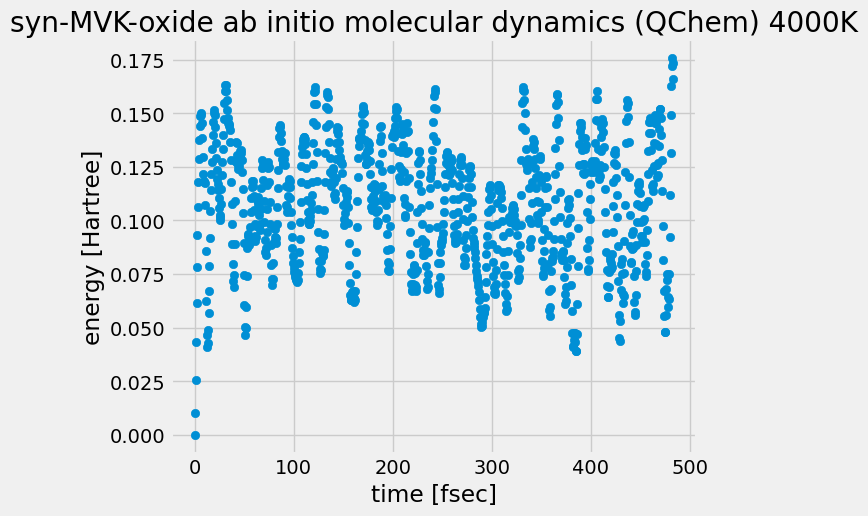

In [5]:
zero_energy = np.array(energy) - min(np.array(energy))
plt.scatter(time,zero_energy)
plt.tight_layout()
plt.xlabel("time [fsec]")
plt.ylabel("energy [Hartree]")
plt.title("syn-MVK-oxide ab initio molecular dynamics (QChem) 4000K")
plt.savefig("syn-MVK-oxide 4000K.png",dpi=300, bbox_inches = "tight")

In [6]:
write_exyz(atoms,energy,coord,"syn-MVK-oxo-4000K.xyz")

In [1]:
ls


 energy_peroxide.png
 energy_water_dimer.png
 ethanol-aims.PBE.TS.light.tier.1-train2000-sym6.npz
 ethanol_ccsd_t-train.xyz
 ethanol_ccsd_t-train.xyz.npz
 ethanol_ccsd_t-train.xyz-unknown-train100-sym6.npz
 ethanol.xyz
 FFT_plot.py*
 IRMDSIM_wl.py*
 MLPES_iPI_PIMD_IR_1.1.py*
 MLPES_MD_IR_MLDIP.py*
 ML_Vibfreq.py*
 molecule.png
 output192979.txt
 QCHEM.py
 QChem_read.ipynb
 qchem_test.txt
 QChem_waterdimer_output192201.txt
 sgdml_cv_syn-MVK-oxo-4000K.xyz-QChem.output-train100-sym/
 sgdml_cv_syn-MVK-oxo-4000K.xyz-QChem.output-train200-sym/
 sgdml_cv_syn-MVK-oxo-4000K.xyz-QChem.output-train400-sym/
 sgdml_cv_syn-MVK-oxo-4000K.xyz-QChem-train400-sym/
 sgdml.ipynb
'sgdm-read exyz.ipynb'
'syn-MVK-oxide 1500K.png'
 syn-MVK-oxide-1500K.txt
'syn-MVK-oxide #193121 4000K.txt'
'syn-MVK-oxide 4000K.png'
 syn-MVK-oxide-aims1.png
 syn-MVK-oxide-aims1.txt
 syn-MVK-oxide-aims.txt
 syn-MVK-oxide.png
 syn-MVK-oxide.txt
 syn-MVK-oxo-1500K.xyz
 syn-MVK-oxo-4000K.xyz
 syn-MVK-oxo-4000K.xyz.npz
 syn-MVK-oxo.